# Factor data folder

Generate the data to compute the factor in the computation

Signals and factors:
 - intersection of 20-day and 50-day moving average, 
 - turtle trading signal with investment when stock reach new low and sell when reach new high
 - Momentum factor - return of 9 month and earnings momentum, Dividends momentum. 
 - Value factor  - EBITDA/EV: (Earnings before Interest, Tax, Depreciation and Amortization) / (Entreprise Value)
 with Enterpise Value = Total Debt + Market Value - Cash
 
Signal output a value +1,-1 to dictate if the rules like a moving average crossing dictates to buy/sell a stock. The factor is a numerical value to which ranking or z-scoring $\frac{x - \mu}{\sigma}$ might indicate the strength of a signal. 

NEED TO DO: FINISH THE LAST FACTOR SIGNALS ONCE DQN IS DONE

## 1. load the libraries and constants

In [146]:
import numpy as np
import pandas as pd
import os

SOURCE_FOLDER = 'Data-processed'
TARGET_FOLDER = 'Data-factor'

DESCRIPTION_FILE = "data_list.csv"
DATA_FILE = "data_content.csv"

## 2. load the data

In [147]:
# Use only the time-series and the static dataset. 
df_desc = pd.read_csv(os.path.join(os.getcwd(),SOURCE_FOLDER, DESCRIPTION_FILE),encoding='utf-8',index_col=0)
df_data = pd.read_csv(os.path.join(os.getcwd(),SOURCE_FOLDER, DATA_FILE),encoding='utf-8', index_col=0)

In [3]:
df_desc.head()

,NAME,SICUR,TYPE
MNEM,,,
PA1436583006,CARNIVAL,NaN,Equity
US22160K1051,COSTCO WHOLESALE,NaN,Equity
US4581401001,INTEL,NaN,Equity
AN8068571086,SCHLUMBERGER,NaN,Equity
NASCOMP,NASDAQ COMPOSITE,NaN,Index


In [4]:
df_data.head()

,PA1436583006-MVC,PA1436583006-P,PA1436583006-PH,PA1436583006-PL,PA1436583006-PO,US22160K1051-MVC,US22160K1051-P,US22160K1051-PH,US22160K1051-PL,US22160K1051-PO,...,USBSINV.B-ES,USCAPUS.R-ES,USCAPUTLQ-ES,USCNFBUSQ-ES,USCNFCONQ-ES,USCRDCONB-ES,USCSHPM%E-ES,USPENONFO-ES,USUMINM1R-ES,ECSWF1Y-IR
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-02,33610.74,39.82,40.25,39.750,39.91,16637.42,36.32,37.420,36.18,37.19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5781
2004-01-05,34121.62,40.43,40.61,40.185,40.28,16559.55,36.15,36.610,35.86,36.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5938
2004-01-06,34297.64,40.75,40.80,40.300,40.43,16747.36,36.56,36.930,36.06,36.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5469
2004-01-07,34380.14,40.83,41.00,40.550,40.70,16985.55,37.08,37.175,36.52,36.58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5781
2004-01-08,34754.78,41.24,41.30,40.850,40.87,17068.01,37.26,37.530,37.02,37.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5156


## 3. Generate factors time-series

### 3.1 Moving-average intersection signal

First, let's start with a classic factor. ie. the intersection of the 20-day moving-average and the 50-day moving-average.

In [39]:
# Compute the moving average using one source i.e. closing price
SHORT_MA = 20
LONG_MA = 50
def moving_average(df, length, isin_name):
    return df.rolling(window=length, min_periods=5, center=False).mean().rename("-".join([isin_name,"MA"]))

def intersection_moving_average(df, length_short, length_long, isin_name):
    df_short = moving_average(df, length_short, isin_name)
    df_long = moving_average(df, length_long, isin_name)
    return pd.Series(np.where(
        df_short[length_short:] > df_long[length_short:],
        1.0, 0.0), index=df_short[length_short:].index).rename("-".join([isin_name,"FMA"]))
    
df_short_ma = pd.concat([
    moving_average(df_data["-".join([isin,"P"])],SHORT_MA,isin) for isin in df_desc[
        df_desc['TYPE'] == 'Equity'].index],axis=1)
df_fast_ma = pd.concat([
    moving_average(df_data["-".join([isin,"P"])],LONG_MA,isin) for isin in df_desc[
        df_desc['TYPE'] == 'Equity'].index],axis=1)
df_signal_ma = pd.concat([
    intersection_moving_average(df_data["-".join([isin,"P"])],SHORT_MA, LONG_MA,isin) for isin in df_desc[
        df_desc['TYPE'] == 'Equity'].index],axis=1)
df_signal_ma

,PA1436583006-FMA,US22160K1051-FMA,US4581401001-FMA,AN8068571086-FMA
Date,,,,
2004-01-30,1.0,1.0,1.0,1.0
2004-02-02,1.0,1.0,0.0,1.0
2004-02-03,1.0,1.0,0.0,1.0
2004-02-04,1.0,1.0,0.0,1.0
2004-02-05,1.0,1.0,0.0,1.0
2004-02-06,1.0,1.0,0.0,1.0
2004-02-09,1.0,1.0,0.0,1.0
2004-02-10,1.0,1.0,0.0,1.0
2004-02-11,1.0,1.0,0.0,1.0


### 3.2 Turtle trading signal

Second, let's start with a classic buy low, sell high turtle trading. Buy when a new low is established and sell when a new high is established.

Comment: that trading strategy would run horrible risk trading metrics.

In [6]:
# Compute the turtle trading using one source, i.e. the closing price. The high low is over 20 days 
WINDOW_HIGH_LOW =  20
def turtle_signal(df, length, isin_name):
    df_max = df.shift(1).rolling(length, min_periods=10, center=False).max()
    df_min = df.shift(1).rolling(length, min_periods=10, center=False).min()
    df_out = pd.Series(0, index=df.index).rename("-".join([isin_name,"FTURTLE"]))
    df_out[df_max < df ]= -1  # Sell when new high
    df_out[df_min > df ]= 1  # Buy when new low                                        
    return df_out
        
df_turtle = pd.concat([
    turtle_signal(df_data["-".join([isin,"P"])],WINDOW_HIGH_LOW,isin) for isin in df_desc[
        df_desc['TYPE'] == 'Equity'].index],axis=1)
df_turtle.head()

,PA1436583006-FTURTLE,US22160K1051-FTURTLE,US4581401001-FTURTLE,AN8068571086-FTURTLE
Date,,,,
2004-01-02,0,0,0,0
2004-01-05,0,0,0,0
2004-01-06,0,0,0,0
2004-01-07,0,0,0,0
2004-01-08,0,0,0,0


### 3.3 Dividend momentum factor.

Dividend rate momentum using the dividend paid divided by the total asset value. 

In [20]:
for isin in df_desc[df_desc['TYPE'] == 'Equity'].index:
    df_data["-".join([isin,"Div_rate"])] = df_data["-".join([isin,"WC05376"])] / df_data["-".join([isin,"WC02999"])]
df_dividend = pd.concat([
    df_data["-".join([isin,"Div_rate"])].rolling(
        window=120, min_periods=5, center=False).mean().rename("-".join([isin,"DIVMOM"])) for isin in df_desc[
        df_desc['TYPE'] == 'Equity'].index],axis=1)
df_dividend

,PA1436583006-DIVMOM,US22160K1051-DIVMOM,US4581401001-DIVMOM,AN8068571086-DIVMOM
Date,,,,
2004-01-02,NaN,NaN,NaN,NaN
2004-01-05,NaN,NaN,NaN,NaN
2004-01-06,NaN,NaN,NaN,NaN
2004-01-07,NaN,NaN,NaN,NaN
2004-01-08,NaN,NaN,NaN,NaN
2004-01-09,NaN,NaN,NaN,NaN
2004-01-12,NaN,NaN,NaN,NaN
2004-01-13,NaN,NaN,NaN,NaN
2004-01-14,NaN,NaN,NaN,NaN


### 3.4 EBITDA to EV factor.

Divide the Earnings before interest tax depreciation and amortisation with the enterprise value with
 - "WC18191" : EBIT
 - "WC01151": Depreciation and Amortisation
 - "MVC": Market Value of a company
 - "WC02001": Cash
 - "WC03255": Total Debt
 
thus:
 ("WC18191" + "WC01151") / ("MVC" * 100 + "WC03255" - "WC02001")

In [16]:
print df_data["-".join(['US22160K1051',"WC02001"])].head()
print df_data["-".join(['US22160K1051',"MVC"])].head()  # multiply by 100 to have the same unit. USD
print df_data["-".join(['US22160K1051',"WC03255"])].head()

Date
2004-01-02          NaN
2004-01-05    2688638.0
2004-01-06          NaN
2004-01-07          NaN
2004-01-08          NaN
Name: US22160K1051-WC02001, dtype: float64
Date
2004-01-02    16637.42
2004-01-05    16559.55
2004-01-06    16747.36
2004-01-07    16985.55
2004-01-08    17068.01
Name: US22160K1051-MVC, dtype: float64
Date
2004-01-02          NaN
2004-01-05    1320935.0
2004-01-06          NaN
2004-01-07          NaN
2004-01-08          NaN
Name: US22160K1051-WC03255, dtype: float64


In [22]:
for isin in df_desc[df_desc['TYPE'] == 'Equity'].index:
    df_data["-".join([isin,"EBITDA2EV"])] = (df_data["-".join([isin,"WC18191"])] + df_data["-".join([isin,"WC01151"])]) / (
    df_data["-".join([isin,"MVC"])] * 100 + df_data["-".join([isin,"WC03255"])] - df_data["-".join([isin,"WC02001"])])
df_ebibtda2ev = pd.concat([
    df_data["-".join([isin,"EBITDA2EV"])] for isin in df_desc[
        df_desc['TYPE'] == 'Equity'].index],axis=1)
df_ebibtda2ev

,PA1436583006-EBITDA2EV,US22160K1051-EBITDA2EV,US4581401001-EBITDA2EV,AN8068571086-EBITDA2EV
Date,,,,
2004-01-02,NaN,NaN,NaN,NaN
2004-01-05,0.279958,6.438075,2.936817,0.559438
2004-01-06,NaN,NaN,NaN,NaN
2004-01-07,NaN,NaN,NaN,NaN
2004-01-08,NaN,NaN,NaN,NaN
2004-01-09,NaN,NaN,NaN,NaN
2004-01-12,0.278724,5.165671,2.542902,0.574223
2004-01-13,NaN,NaN,NaN,NaN
2004-01-14,NaN,NaN,NaN,NaN


### 3.5 trailing return factor.

fast 1-month and slow 9-month trailing returns.
Since there is 20 trading days in a month we have 1 month = 20 days  and 9 months = 180 days

In [34]:
FAST_TRAIL = 20
SLOW_TRAIL = 180
for isin in df_desc[df_desc['TYPE'] == 'Equity'].index:
    df_data["-".join([isin,"FST"])] = df_data["-".join([isin,"P"])].pct_change(periods=FAST_TRAIL)
    df_data["-".join([isin,"SLW"])] = df_data["-".join([isin,"P"])].pct_change(periods=SLOW_TRAIL)
df_slow_trailing_rtn = pd.concat([
    df_data["-".join([isin,"SLW"])] for isin in df_desc[
        df_desc['TYPE'] == 'Equity'].index],axis=1)
df_fast_trailing_rtn = pd.concat([
    df_data["-".join([isin,"FST"])] for isin in df_desc[
        df_desc['TYPE'] == 'Equity'].index],axis=1)                                    

Other factor to be implemented:
as previous one, backward looking factors for single stocks:
 - Total Assets to Price =  "WC02999" / "MVC" *100
 - Moving average of Current Ratio = MA("WC08106") :"CURRENT RATIO" (Ability to pay debt),
 - Moving average of Profitability = MA("WC08316") :"OPERATING PROFIT MARGIN",

also for indices and market conditions:
 -  Trailing returns of major indices,
 - Moving average of Profitability = MA("WC08316") :"OPERATING PROFIT MARGIN", 

forward looking indicators, 
 - difference between volume Call and Put for a stock weighted by open interest: "OI":"Open Interest", "O3": "Implied Volatility - 3 Month Constant Maturity (Cont Series)"
 - difference between volume Call and Put for an index weighted by open interest: "OI":"Open Interest", "O3": "Implied Volatility - 3 Month Constant Maturity (Cont Series)"
 - slope of Out-of-the-money us At-the-money:  (ie risk metrics of Deep out of the money put)

## 4. Output results

In [38]:
# Save the trading signal
df_signal_ma.to_csv(os.path.join(os.getcwd(),TARGET_FOLDER, 'moving_average_signal.csv'), encoding='utf-8')
df_turtle.to_csv(os.path.join(os.getcwd(),TARGET_FOLDER, 'turtle_signal.csv'), encoding='utf-8')

# Save the trading factors.
df_factor_ts = pd.concat([df_dividend, df_ebibtda2ev, df_slow_trailing_rtn,
           df_fast_trailing_rtn], axis=1,sort=True)
df_factor_ts.to_csv(os.path.join(os.getcwd(),TARGET_FOLDER, 'data_factor.csv'), encoding='utf-8')
df_factor_ts.tail()

,PA1436583006-DIVMOM,US22160K1051-DIVMOM,US4581401001-DIVMOM,AN8068571086-DIVMOM,PA1436583006-EBITDA2EV,US22160K1051-EBITDA2EV,US4581401001-EBITDA2EV,AN8068571086-EBITDA2EV,PA1436583006-SLW,US22160K1051-SLW,US4581401001-SLW,AN8068571086-SLW,PA1436583006-FST,US22160K1051-FST,US4581401001-FST,AN8068571086-FST
Date,,,,,,,,,,,,,,,,
2013-12-25,0.027459,0.046814,0.048725,0.023964,NaN,NaN,NaN,NaN,0.189385,0.128661,0.111451,0.239787,0.089804,-0.053358,0.064017,0.004093
2013-12-26,0.027391,0.043738,0.048725,0.023964,NaN,NaN,NaN,NaN,0.179242,0.106107,0.099465,0.242563,0.094988,-0.054214,0.078020,0.010970
2013-12-27,0.027391,0.043738,0.048725,0.023964,NaN,NaN,NaN,NaN,0.197179,0.099230,0.081995,0.228646,0.105599,-0.041717,0.080169,0.026256
2013-12-30,0.027067,0.042653,0.048706,0.023964,0.266737,1.442688,2.060182,0.775365,0.159780,0.088335,0.105646,0.214188,0.119665,-0.040785,0.097665,0.017458
2013-12-31,0.027067,0.042653,0.048706,0.023964,NaN,NaN,NaN,NaN,0.165699,0.089229,0.109188,0.228661,0.129958,-0.032122,0.093302,0.032424


In [24]:
# Functions - Case for one -
df_get_one = pd.concat([df_data["-".join([isin,"P"])] for isin in df_desc[df_desc['TYPE'] == 'Equity'].index],axis=1)
df_get_one.head()


,PA1436583006-P,US9497461015-P,US22160K1051-P,US4581401001-P,AN8068571086-P
Date,,,,,
2004-01-02,39.82,29.085,36.32,32.16,27.330
2004-01-05,40.43,29.225,36.15,32.91,27.755
2004-01-06,40.75,29.130,36.56,32.90,27.455
2004-01-07,40.83,28.835,37.08,33.99,26.775
2004-01-08,41.24,28.825,37.26,34.24,26.925


In [62]:
# Function - Case for two
letter_array = ["P", "PH"]
array_mnemonic = ["-".join([isin,letter]) for letter in letter_array]
df_get_n = pd.concat([df_data["-".join([isin,letter])] for isin in df_desc[df_desc['TYPE'] == 'Equity'].index for letter in letter_array],axis=1)
df_get_n.head()

,PA1436583006-P,PA1436583006-PH,US4581401001-P,US4581401001-PH,US22160K1051-P,US22160K1051-PH,US92343E1029-P,US92343E1029-PH,AN8068571086-P,AN8068571086-PH
Date,,,,,,,,,,
2005-01-03,57.31,58.24,23.07,23.79,47.90,48.99,32.56,33.67,32.125,33.400
2005-01-04,57.05,57.85,22.61,23.21,47.04,48.34,31.47,32.70,31.880,32.505
2005-01-05,56.95,57.27,22.39,22.78,47.22,47.86,30.64,31.67,31.980,32.255
2005-01-06,57.36,57.48,22.46,22.73,47.90,48.89,30.58,31.05,32.605,32.780
2005-01-07,57.50,57.88,22.80,22.93,47.49,47.96,30.95,32.38,31.765,32.425


In [59]:
letter_array = ["P", "PH"]
array_mnemonic = ["-".join([isin,letter]) for letter in letter_array]
pd.concat([df_data["-".join([isin,letter])] for isin in df_desc[df_desc['TYPE'] == 'Equity'].index for letter in letter_array],axis=1)



,PA1436583006-P,PA1436583006-PH,US4581401001-P,US4581401001-PH,US22160K1051-P,US22160K1051-PH,US92343E1029-P,US92343E1029-PH,AN8068571086-P,AN8068571086-PH
Date,,,,,,,,,,
2005-01-03,57.31,58.24,23.0700,23.790,47.90,48.9900,32.56,33.6700,32.125,33.400
2005-01-04,57.05,57.85,22.6100,23.210,47.04,48.3400,31.47,32.7000,31.880,32.505
2005-01-05,56.95,57.27,22.3900,22.780,47.22,47.8600,30.64,31.6700,31.980,32.255
2005-01-06,57.36,57.48,22.4600,22.730,47.90,48.8900,30.58,31.0500,32.605,32.780
2005-01-07,57.50,57.88,22.8000,22.930,47.49,47.9600,30.95,32.3800,31.765,32.425
2005-01-10,56.79,57.38,22.8800,23.020,47.58,47.9400,30.83,31.2000,31.960,32.325
2005-01-11,56.09,56.79,22.5400,22.780,47.32,47.5600,30.44,31.7100,31.735,32.090
2005-01-12,56.13,56.23,23.1600,23.330,47.53,47.6400,29.93,30.6400,32.015,32.055
2005-01-13,56.32,56.50,22.8200,23.210,47.74,48.4000,28.56,30.0400,32.100,32.510


In [ ]:
# Compute x using two sources


## 3. Presentation of factor investing

Put Black litterman and all the shit here

In [140]:
# Presentation to buy the stock and illustrate
def buy_stock(real_movement, signal, initial_money = 10000, max_buy = 1, max_sell = 1):
    """
    real_movement = Stock price time-series - pandas dataframe
    signal = Buy/Sell signals - pandas dataframe
    initial_money: Value of funds to invest (unitary monetary value, i.e. USD)
    max_buy : Quantity to buy at each positive signal
    max_sell : Quantity to sell at each negative signal
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0  # inventory of the stocks (Check that we don't invest all)

    def buy(i, initial_money, current_inventory):
        """
        Implement the buy signal
        i: position index
        initial_money: Cash amount available at t
        current_inventory: inventory of stock - positive integer
        """
        shares = initial_money // real_movement[i]  # Get the number available
#         print "Value money", initial_money
#         print "Stock", np.isnan(real_movement[i])
#         print "Stock", real_movement.index[i]
#         print "Nb shares", shares
        if shares < 1:
            print('day nb %d -date %s: total balances %f, not enough money to buy a unit price %f'
                % (i, real_movement.index[i],  initial_money, real_movement[i]))
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print('day nb %d -date %s: buy %d units at price %f, total balance %f'
                % (i, real_movement.index[i], buy_units, buy_units * real_movement[i], initial_money))
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * real_movement.shape[0])):
        state = signal[i]
        if state == 1:
            # Check if value is NaN
            if not np.isnan(real_movement[i]):
                initial_money, current_inventory = buy(i, initial_money, current_inventory)
                states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day nb %d -date %s: cannot sell anything, inventory 0' % (i, real_movement.index[i]))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print('day nb %d -date %s, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, real_movement.index[i], sell_units, total_sell, invest, initial_money))
            states_sell.append(i)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [141]:
# Execution with turtle
states_buy, states_sell, total_gains, invest = buy_stock(df_data['PA1436583006-P'], df_turtle['PA1436583006-FTURTLE'])

day nb 10 -date 2004-01-16: cannot sell anything, inventory 0
day nb 12 -date 2004-01-20: cannot sell anything, inventory 0
day nb 16 -date 2004-01-26: cannot sell anything, inventory 0
day nb 19 -date 2004-01-29: cannot sell anything, inventory 0
day nb 20 -date 2004-01-30: cannot sell anything, inventory 0
day nb 21 -date 2004-02-02: cannot sell anything, inventory 0
day nb 33 -date 2004-02-17: cannot sell anything, inventory 0
day nb 50 -date 2004-03-11: buy 1 units at price 42.460000, total balance 9957.540000
day nb 52 -date 2004-03-15: buy 1 units at price 41.470000, total balance 9916.070000
day nb 53 -date 2004-03-16: buy 1 units at price 40.910000, total balance 9875.160000
day nb 66 -date 2004-04-02, sell 1 units at price 45.940000, investment 12.295282 %, total balance 9921.100000,
day nb 67 -date 2004-04-05, sell 1 units at price 46.140000, investment 12.784160 %, total balance 9967.240000,
day nb 68 -date 2004-04-06, sell 1 units at price 46.370000, investment 13.346370 %,

In [142]:
print(total_gains, invest)

(-324.6499999999887, -3.246499999999887)


In [143]:
# Execution with Moving Average
states_buy, states_sell, total_gains, invest = buy_stock(df_data['PA1436583006-P'], df_signal_ma['PA1436583006-FMA'])

day nb 0 -date 2004-01-02: buy 1 units at price 39.820000, total balance 9960.180000
day nb 1 -date 2004-01-05: buy 1 units at price 40.430000, total balance 9919.750000
day nb 2 -date 2004-01-06: buy 1 units at price 40.750000, total balance 9879.000000
day nb 3 -date 2004-01-07: buy 1 units at price 40.830000, total balance 9838.170000
day nb 4 -date 2004-01-08: buy 1 units at price 41.240000, total balance 9796.930000
day nb 5 -date 2004-01-09: buy 1 units at price 41.030000, total balance 9755.900000
day nb 6 -date 2004-01-12: buy 1 units at price 41.040000, total balance 9714.860000
day nb 7 -date 2004-01-13: buy 1 units at price 40.820000, total balance 9674.040000
day nb 8 -date 2004-01-14: buy 1 units at price 42.280000, total balance 9631.760000
day nb 9 -date 2004-01-15: buy 1 units at price 42.870000, total balance 9588.890000
day nb 10 -date 2004-01-16: buy 1 units at price 43.650000, total balance 9545.240000
day nb 12 -date 2004-01-20: buy 1 units at price 43.900000, tota

day nb 2230 -date 2012-06-12: total balances 2.340000, not enough money to buy a unit price 33.820000
day nb 2231 -date 2012-06-13: total balances 2.340000, not enough money to buy a unit price 33.580000
day nb 2232 -date 2012-06-14: total balances 2.340000, not enough money to buy a unit price 34.560000
day nb 2233 -date 2012-06-15: total balances 2.340000, not enough money to buy a unit price 34.760000
day nb 2234 -date 2012-06-18: total balances 2.340000, not enough money to buy a unit price 34.720000
day nb 2235 -date 2012-06-19: total balances 2.340000, not enough money to buy a unit price 35.110000
day nb 2236 -date 2012-06-20: total balances 2.340000, not enough money to buy a unit price 35.340000
day nb 2237 -date 2012-06-21: total balances 2.340000, not enough money to buy a unit price 34.580000
day nb 2238 -date 2012-06-22: total balances 2.340000, not enough money to buy a unit price 33.660000
day nb 2239 -date 2012-06-25: total balances 2.340000, not enough money to buy a u

In [144]:
print(total_gains, invest)

(-9997.660000000009, -99.97660000000009)


In [214]:
df_data['PA1436583006-P'].index[states_buy[:20]], states_buy[:20]
[ i*2 for i in range(10)]
print states_buy[:20] 
print [ i*2 for i in range(10)]
print type(states_buy[:20][0])
print type([ i*2 for i in range(10)][0])
[i for i in states_buy[:20] if i >0 ]

[0, 80, 0, 81, 0, 82, 0, 83, 0, 84, 0, 85, 0, 86, 0, 87, 0, 88, 0, 89]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
<type 'int'>
<type 'int'>


[80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

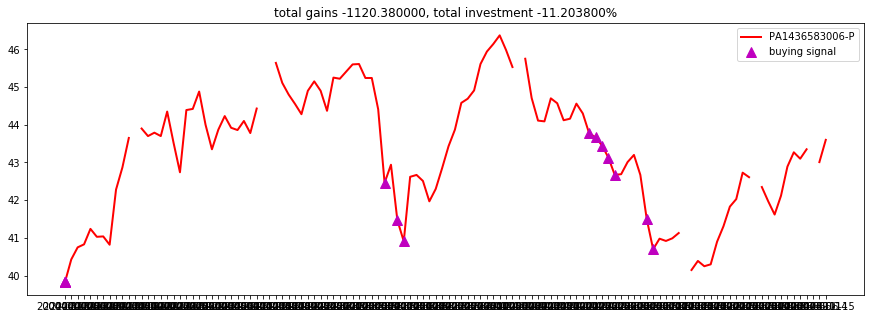

In [135]:
import matplotlib.pyplot as plt
%matplotlib inline
close = df_data['PA1436583006-P'][:120]
# Comment Be careful about the position of the markers to mix with close. 

fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery =states_buy[:20] )
#plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell[:20])
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))

plt.legend()
#plt.savefig('output/'+name+'.png')
plt.show()

Policy gradient agent

In [224]:
import tensorflow as tf
df = df_data['PA1436583006-P'][:120].copy()# df = df_full.copy()
name = 'Policy Gradient agent'
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

ImportError: No module named tensorflow

In [220]:
import tensor
close = df.values.tolist() ##close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

NameError: global name 'tf' is not defined

__Q-learning agent__

In [218]:
from collections import deque
import random

df= df_full.copy()
name = 'Q-learning agent'

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

NameError: name 'df_full' is not defined

In [ ]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)